# Wavenet

We will: <br>
1. we will pytorchify our code, meaning _formailize_ it by creating multiple classes with __same API__ as `pytorch.nn` and use those classes. 
2. Make modifications in the starter code and move towards our goal of a more complex architecture and high context size. 



<img title="a title" alt="Alt text" src="images/dilated cnn.png" width=60%>

__Core idea:__ 'progressive fusion' -- we make the network deeper and at each layer only fuse 2 consecutive characters to find the next char. <br>
i.e. 2 chars -> 2 bigrams -> 2 quadgrams and so on.. 


In [33]:
import torch 
import torch.nn as nn 
import matplotlib.pyplot as plt

# to ensure changes in aux_files are reflected dynamically
import importlib
import aux_files
importlib.reload(aux_files)
from aux_files import Linear, BatchNorm1d, Tanh, Embedding, Flatten, Sequential

In [24]:
words = open('names.txt').read().splitlines()

In [25]:
allchars = sorted(set(''.join(words)))

stoi = {s:i+1 for i,s in enumerate(allchars)}
stoi['.'] = 0

itos = {i:s for s,i in stoi.items()}

vocab_size = len(itos)

Increase context length to 8, as we deepen the network. 

In [55]:
# build the dataset
block_size = 8 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
words_shuffled = words[:]  # shallow copy -- to preserve across runs
random.shuffle(words_shuffled)
n1 = int(0.8*len(words_shuffled))
n2 = int(0.9*len(words_shuffled))

Xtr,  Ytr  = build_dataset(words_shuffled[:n1])     # 80%
Xdev, Ydev = build_dataset(words_shuffled[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words_shuffled[n2:])     # 10%

torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [56]:
for x,y in zip(Xtr[:20], Ytr[:20]):
  print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

........ --> y
.......y --> u
......yu --> h
.....yuh --> e
....yuhe --> n
...yuhen --> g
..yuheng --> .
........ --> d
.......d --> i
......di --> o
.....dio --> n
....dion --> d
...diond --> r
..diondr --> e
.diondre --> .
........ --> x
.......x --> a
......xa --> v
.....xav --> i
....xavi --> e


The layers can be wrapped in a 'container', instead of a list. An equivalant of this is the [torch.nn.Sequential()](https://docs.pytorch.org/docs/stable/generated/torch.nn.Sequential.html) class. 

In [57]:
g = torch.Generator().manual_seed(3445676536)

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP
batch_size = 32

C = torch.randn((vocab_size, n_embd))

model = Sequential([
    Embedding(vocab_size, n_embd), Flatten(),
    Linear(n_embd*block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(), 
    Linear(n_hidden, vocab_size, bias=True)
])

parameters = model.parameters()
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

22097


Defining `Embedding`, `Flatten` and `Sequential` classes eliminates the needs for explicit forward pass operation as such: 

```
emb = C[Xb]
x = emb.view(emb.shape[0], -1)
```

In [58]:
# Optimization loop - same as earlier

max_iters = 200000
lossi = []

for iter in range(max_iters):

    # define batch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    logits = model(Xb)
    loss = nn.functional.cross_entropy(logits, Yb)

    # backward pass
    for p in parameters:
        p.grad = None # flush gradients
    loss.backward()

    # update - SGD
    lr = 0.1 if iter < 100000 else 0.01
    for p in parameters:
        p.data += -lr*p.grad

    #print
    lossi.append(loss.item())
    if iter % 10000 == 0:
        print(f'iter: {iter}/{max_iters}: loss = {loss.item()}')
    
    # if iter == 10001:
    #     break


iter: 0/200000: loss = 3.3512282371520996
iter: 10000/200000: loss = 1.924323558807373
iter: 20000/200000: loss = 1.811569333076477
iter: 30000/200000: loss = 2.3411850929260254
iter: 40000/200000: loss = 2.214951276779175
iter: 50000/200000: loss = 2.1932904720306396
iter: 60000/200000: loss = 2.4714550971984863
iter: 70000/200000: loss = 2.283942461013794
iter: 80000/200000: loss = 2.362306594848633
iter: 90000/200000: loss = 1.989919662475586
iter: 100000/200000: loss = 1.6614701747894287
iter: 110000/200000: loss = 2.0225279331207275
iter: 120000/200000: loss = 2.0805504322052
iter: 130000/200000: loss = 1.9134904146194458
iter: 140000/200000: loss = 2.4197797775268555
iter: 150000/200000: loss = 1.7430682182312012
iter: 160000/200000: loss = 2.5064070224761963
iter: 170000/200000: loss = 2.079756498336792
iter: 180000/200000: loss = 2.4682724475860596
iter: 190000/200000: loss = 2.102435350418091


The `lossi` plot is too jagged; party because of the __small batch size__ - the randomness in batch gradient is too volatile. Lets fix this by only plotting the average loss across 200 batches of 1000 iterations each. 

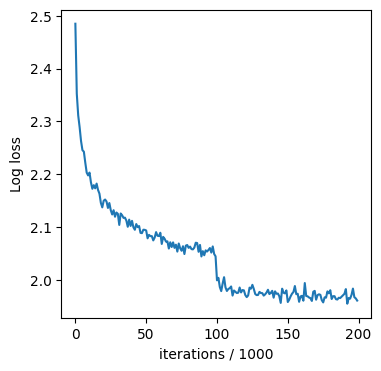

In [59]:
lossi = torch.tensor(lossi)
lossi = lossi.view(-1,1000) # 200,1000

plt.figure(figsize=(4,4))
plt.plot(lossi.mean(dim = 1)) # 200 points only across all iterations
plt.ylabel('Log loss')
plt.xlabel('iterations / 1000')
plt.show()

The steep drop at 100000 is a result of the decay in learning rate which helps a finer local search for minimizing loss. 


## On setting training = False while sampling:

One very clear result of not setting the __training mode off__, is that while sampling names each example will be considered as a 'batch' by BatchNorm1d class and calculate the variance (=`NaN`) on that batch (made of single example). In refined language:

"
..so every BatchNorm* layer is trying to compute its _mean/variance from a single (length-1) “batch”_ at generation time — variance goes to 0, the division blows up, and the NaNs propagate all the way to softmax
"

In [60]:
# to ensure batch norm parameters are not trainined on eval data!
for layer in model.layers:
    layer.training = False

In [61]:
@torch.no_grad()
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  logits = model(x)
  loss = torch.nn.functional.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')


train 1.9279884099960327
val 2.0243895053863525


### Performance log: 

- original (3 char context + 1 hidden layer - 200 neurons; 12k parameters): train 2.06, val: 2.10
- context: 3 -> 8 (22k params): train: 1.92, val: 2.02

In [62]:
# sample from the model
for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      logits = model(torch.tensor([context]))
      probs = torch.nn.functional.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

jesab.
cort.
arisa.
rahima.
shamari.
niyah.
julina.
ifiyan.
cymile.
jarini.
kaeli.
desleigh.
granike.
emalee.
lamion.
mohe.
graylen.
evannah.
lesie.
mazayio.
